# Trying out CNN on Structure Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
# import tensorflow_datasets as tfds
import tensorflow_addons as tfa
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense, Reshape, Conv1D, AveragePooling1D, Multiply, MaxPool1D, Flatten, Activation
from tensorflow_addons.layers import WeightNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

In [2]:
def cnn_model( num_columns, num_labels):
    inp = Input(shape=(num_columns,))
    x = BatchNormalization()(inp)
    x = Dropout(0.1)(x)
    x = WeightNormalization(Dense(4096))(x)
    x = Reshape((256, 16))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = WeightNormalization(Conv1D(filters = 16, kernel_size = 5, activation = 'relu', use_bias = False, padding = 'SAME'))(x)
    x = AveragePooling1D(pool_size = 2)(x)
    xs = x
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = WeightNormalization(Conv1D(filters = 16, kernel_size = 3, activation = 'relu', use_bias = True, padding = 'SAME'))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = WeightNormalization(Conv1D(filters = 16, kernel_size = 3, activation = 'relu', use_bias = True, padding = 'SAME'))(x)
    x = Multiply()([x, xs])
    x = MaxPool1D(pool_size = 4, strides = 2)(x)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dense(num_labels)(x)
    out = Activation('sigmoid')(x)
    model = Model(inputs=inp, outputs=out)
    # model.summary()
    return model

In [3]:
BATCH_SIZE = 32
EPOCHS = 20

### Titanic Dataset

In [4]:
titanic = sns.load_dataset('titanic')
titanic['age'] = titanic['age'].fillna(titanic['age'].median())
titanic['embarked'] = titanic['embarked'].mode()[0]
titanic['deck'] = titanic['deck'].mode()[0]
titanic['embark_town'] = titanic['embark_town'].mode()[0]

string_list = titanic.select_dtypes(include = ['object', 'category', 'bool']).columns
le = LabelEncoder()
titanic[string_list] = titanic[string_list].apply(le.fit_transform)

display(titanic.isnull().sum())
display(titanic.info())
display(titanic)

survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       0
class          0
who            0
adult_male     0
deck           0
embark_town    0
alive          0
alone          0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    int32  
 3   age          891 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     891 non-null    int32  
 8   class        891 non-null    int32  
 9   who          891 non-null    int32  
 10  adult_male   891 non-null    int64  
 11  deck         891 non-null    int32  
 12  embark_town  891 non-null    int32  
 13  alive        891 non-null    int32  
 14  alone        891 non-null    int64  
dtypes: float64(2), int32(7), int64(6)
memory usage: 80.2 KB


None

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,1,22.0,1,0,7.2500,0,2,1,1,0,0,0,0
1,1,1,0,38.0,1,0,71.2833,0,0,2,0,0,0,1,0
2,1,3,0,26.0,0,0,7.9250,0,2,2,0,0,0,1,1
3,1,1,0,35.0,1,0,53.1000,0,0,2,0,0,0,1,0
4,0,3,1,35.0,0,0,8.0500,0,2,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,0,1,1,1,0,0,0,1
887,1,1,0,19.0,0,0,30.0000,0,0,2,0,0,0,1,1
888,0,3,0,28.0,1,2,23.4500,0,2,2,0,0,0,0,0
889,1,1,1,26.0,0,0,30.0000,0,0,1,1,0,0,1,1


In [5]:
X = titanic.drop(columns='survived')
y = titanic['survived']
trainX, testX, trainy, testy = train_test_split(X, y, test_size=.2, random_state=7)
display(trainX.shape)
display(trainy.shape)

(712, 14)

(712,)

In [6]:
neg = titanic['survived'].value_counts()[0]
pos = titanic['survived'].value_counts()[1]
weight_for_0 = (1 / neg) * (neg + pos / 2.0)
weight_for_1 = (1 / pos) * (neg + pos / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

In [7]:
cnn = cnn_model(num_columns=14, num_labels=1)
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
titanic_history = cnn.fit(trainX, 
                          trainy, 
                          batch_size=BATCH_SIZE, 
                          epochs=EPOCHS, 
                          validation_data=(testX, testy), 
                          class_weight=class_weight)

Epoch 1/20
23/23 [==============================] - 4s 76ms/step - loss: 0.7324 - accuracy: 0.8333 - val_loss: 0.3491 - val_accuracy: 0.9162
Epoch 2/20
23/23 [==============================] - 0s 17ms/step - loss: 0.1570 - accuracy: 0.9761 - val_loss: 0.0774 - val_accuracy: 0.9888
Epoch 3/20
23/23 [==============================] - 0s 15ms/step - loss: 0.1180 - accuracy: 0.9777 - val_loss: 0.1550 - val_accuracy: 0.9330
Epoch 4/20
23/23 [==============================] - 0s 15ms/step - loss: 0.1056 - accuracy: 0.9741 - val_loss: 0.0963 - val_accuracy: 1.0000
Epoch 5/20
23/23 [==============================] - 0s 16ms/step - loss: 0.0734 - accuracy: 0.9875 - val_loss: 0.0832 - val_accuracy: 0.9888
Epoch 6/20
23/23 [==============================] - 0s 15ms/step - loss: 0.1598 - accuracy: 0.9746 - val_loss: 0.0715 - val_accuracy: 1.0000
Epoch 7/20
23/23 [==============================] - 0s 15ms/step - loss: 0.1050 - accuracy: 0.9732 - val_loss: 0.0653 - val_accuracy: 1.0000
Epoch 8/20
23

### Planet Dataset

In [8]:
planets = sns.load_dataset('planets')
floating = planets.select_dtypes(include = ['float64']).columns
planets[floating] = planets[floating].fillna(planets[floating].median())
planets = planets[planets['method'].str.contains('Radial Velocity|Transit')]
planets = planets[planets['method'] != 'Transit Timing Variations']
le = LabelEncoder()
titanic[string_list] = titanic[string_list].apply(le.fit_transform)
planets['method'] = le.fit_transform(planets['method'])

display(planets.isnull().sum())
display(planets.info())
display(planets)

method            0
number            0
orbital_period    0
mass              0
distance          0
year              0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 950 entries, 0 to 1034
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   method          950 non-null    int32  
 1   number          950 non-null    int64  
 2   orbital_period  950 non-null    float64
 3   mass            950 non-null    float64
 4   distance        950 non-null    float64
 5   year            950 non-null    int64  
dtypes: float64(3), int32(1), int64(2)
memory usage: 48.2 KB


None

,method,number,orbital_period,mass,distance,year
0,0,1,269.300000,7.10,77.40,2006
1,0,1,874.774000,2.21,56.95,2008
2,0,1,763.000000,2.60,19.84,2011
3,0,1,326.030000,19.40,110.62,2007
4,0,1,516.220000,10.50,119.47,2009
...,...,...,...,...,...,...
1030,1,1,3.941507,1.26,172.00,2006
1031,1,1,2.615864,1.26,148.00,2007
1032,1,1,3.191524,1.26,174.00,2007
1033,1,1,4.125083,1.26,293.00,2008


In [9]:
X = planets.drop(columns='method')
y = planets['method']
trainX, testX, trainy, testy = train_test_split(X, y, test_size=.2, random_state=7)
display(trainX.shape)
display(trainy.shape)

(760, 5)

(760,)

In [10]:
neg = planets['method'].value_counts()[0]
pos = planets['method'].value_counts()[1]
weight_for_0 = (1 / neg) * (neg + pos / 2.0)
weight_for_1 = (1 / pos) * (neg + pos / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

In [11]:
cnn = cnn_model(num_columns=5, num_labels=1)
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
planet_history = cnn.fit(trainX, 
                         trainy, 
                         batch_size=BATCH_SIZE, 
                         epochs=EPOCHS, 
                         validation_data=(testX, testy), 
                         class_weight=class_weight)

Epoch 1/20
24/24 [==============================] - 3s 51ms/step - loss: 0.8239 - accuracy: 0.7200 - val_loss: 7916.3320 - val_accuracy: 0.5579
Epoch 2/20
24/24 [==============================] - 0s 16ms/step - loss: 0.5034 - accuracy: 0.8751 - val_loss: 14616.1729 - val_accuracy: 0.5579
Epoch 3/20
24/24 [==============================] - 0s 15ms/step - loss: 0.4173 - accuracy: 0.8812 - val_loss: 5630.7290 - val_accuracy: 0.5579
Epoch 4/20
24/24 [==============================] - 0s 15ms/step - loss: 0.3279 - accuracy: 0.9148 - val_loss: 4045.6045 - val_accuracy: 0.5579
Epoch 5/20
24/24 [==============================] - 0s 16ms/step - loss: 0.3711 - accuracy: 0.9205 - val_loss: 1170.5088 - val_accuracy: 0.5579
Epoch 6/20
24/24 [==============================] - 0s 15ms/step - loss: 0.3135 - accuracy: 0.9336 - val_loss: 639.5737 - val_accuracy: 0.5579
Epoch 7/20
24/24 [==============================] - 0s 15ms/step - loss: 0.3287 - accuracy: 0.9080 - val_loss: 872.6740 - val_accuracy: 

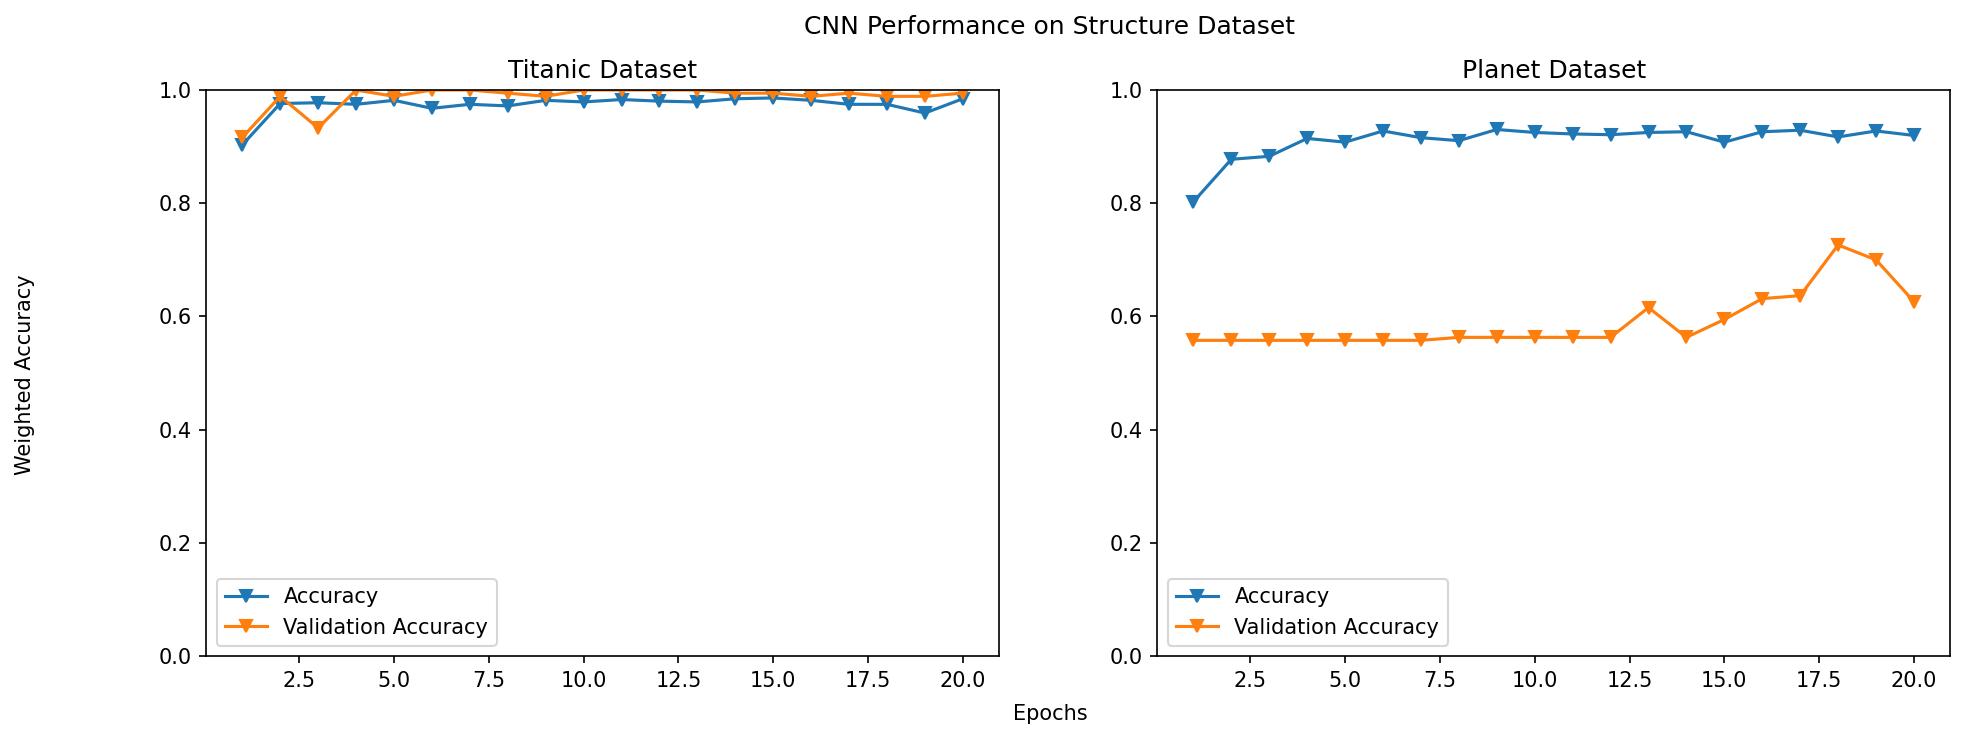

In [12]:
x_label = np.arange(1, EPOCHS+1, 1)

fig, ax = plt.subplots(1,2, figsize=(15,5), dpi=150, sharex=True)
# ax[0].plot(x_label, titanic_history.history['loss'], marker='o', label='Loss')
# ax[0].plot(x_label, titanic_history.history['val_loss'], marker='o', label='Validation Loss')
ax[0].plot(x_label, titanic_history.history['accuracy'], marker='v', label='Accuracy')
ax[0].plot(x_label, titanic_history.history['val_accuracy'], marker='v', label='Validation Accuracy')
ax[0].set_ylim([0,1])
ax[0].set_title('Titanic Dataset')
ax[0].legend()

# ax[1].plot(x_label, planet_history.history['loss'], marker='o', label='Loss')
# ax[1].plot(x_label, planet_history.history['val_loss'], marker='o', label='Validation Loss')
ax[1].plot(x_label, planet_history.history['accuracy'], marker='v', label='Accuracy')
ax[1].plot(x_label, planet_history.history['val_accuracy'], marker='v', label='Validation Accuracy')
ax[1].set_ylim([0,1])
ax[1].set_title('Planet Dataset')
ax[1].legend()

fig.suptitle('CNN Performance on Structure Dataset')
fig.text(0.5, 0.04, 'Epochs', ha='center')
fig.text(0.04, 0.5, 'Weighted Accuracy', va='center', rotation='vertical')

plt.show()